In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


## Котировки

In [2]:
df = pd.read_csv('Data/TQBR.SBER_D1.txt', sep='\t')

In [3]:
def func_1(x):
    
    return datetime.strptime(x[:10], '%d.%m.%Y')

df.datetime = df.datetime.apply(lambda x: func_1(x))
df.datetime = df.datetime.astype('datetime64')

C:\Users\yaroslav\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


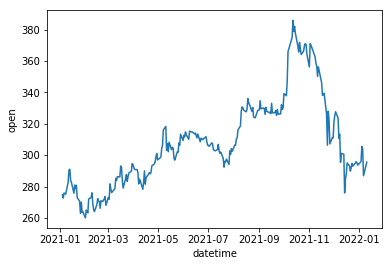

In [4]:
sns.lineplot(data=df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')], x="datetime", y="open")

In [5]:
df = df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')].set_index('datetime')
df.head()

,open,high,low,close,volume
datetime,,,,,
2021-01-04,274.67,276.60,270.61,272.00,4879946
2021-01-05,272.67,275.70,270.28,275.20,4555410
2021-01-06,275.90,275.92,271.62,272.93,4090534
2021-01-08,275.11,283.99,275.11,283.64,8867294
2021-01-11,282.75,292.95,279.48,289.49,11221040


## Индикатор

In [6]:
# STOCHASTIC OSCILLATOR CALCULATION

def get_stoch_osc(high, low, close, k_lookback, d_lookback):
    lowest_low = low.rolling(k_lookback).min()
    highest_high = high.rolling(k_lookback).max()
    k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
    d_line = k_line.rolling(d_lookback).mean()
    return k_line, d_line

df['%k'], df['%d'] = get_stoch_osc(df['high'], df['low'], df['close'], 14, 3)
df.tail()

,open,high,low,close,volume,%k,%d
datetime,,,,,,,
2022-01-03,295.90,305.50,294.34,305.47,5015626,99.910233,80.371451
2022-01-04,305.51,310.10,301.63,304.24,5326822,80.887149,85.149569
2022-01-05,303.56,304.26,287.00,287.01,7001594,5.639559,62.145647
2022-01-06,286.86,295.10,281.00,293.92,7932941,44.398625,43.641778
2022-01-10,295.52,298.88,289.60,291.41,4619797,35.773196,28.603793


In [7]:
# MACD CALCULATION

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    return macd, signal, hist

df['macd'] = get_macd(df['close'], 26, 12, 9)[0]
df['macd_signal'] = get_macd(df['close'], 26, 12, 9)[1]
df['macd_hist'] = get_macd(df['close'], 26, 12, 9)[2]
df = df.dropna()
df.tail()

,open,high,low,close,volume,%k,%d,macd,macd_signal,macd_hist
datetime,,,,,,,,,,
2022-01-03,295.90,305.50,294.34,305.47,5015626,99.910233,80.371451,-6.793205,-9.610469,2.817264
2022-01-04,305.51,310.10,301.63,304.24,5326822,80.887149,85.149569,-5.672035,-8.822782,3.150747
2022-01-05,303.56,304.26,287.00,287.01,7001594,5.639559,62.145647,-6.103461,-8.278918,2.175457
2022-01-06,286.86,295.10,281.00,293.92,7932941,44.398625,43.641778,-5.820692,-7.787273,1.966581
2022-01-10,295.52,298.88,289.60,291.41,4619797,35.773196,28.603793,-5.733044,-7.376427,1.643383


## TRADING STRATEGY

In [23]:
# TRADING STRATEGY

def implement_stoch_macd_strategy(prices, k, d, macd, macd_signal):    
    buy_price = []
    sell_price = []
    stoch_macd_signal = []
    signal = 0

    for i in range(len(prices)):
        #if k[i] < 30 and d[i] < 30 and macd[i] < -2 and macd_signal[i] < -2:
        
        if ((k[i] < 30) and (d[i] < 30)) | (macd[i] > macd_signal[i]):
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
                
        elif ((k[i] > 30) and (d[i] > 30)) | (macd[i] < macd_signal[i]):
            if signal != -1 and signal != 0:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
        
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_macd_signal.append(0)
            
    return buy_price, sell_price, stoch_macd_signal
            
buy_price, sell_price, stoch_macd_signal = implement_stoch_macd_strategy(df['close'], df['%k'], df['%d'], df['macd'], df['macd_signal'])

## POSITION

In [24]:
# POSITION

position = []
for i in range(len(stoch_macd_signal)):
    if stoch_macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if stoch_macd_signal[i] == 1:
        position[i] = 1
    elif stoch_macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = df['close']
k_line = df['%k']
d_line = df['%d']
macd_line = df['macd']
signal_line = df['macd_signal']
stoch_macd_signal = pd.DataFrame(stoch_macd_signal).rename(columns = {0:'stoch_macd_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'stoch_macd_position'}).set_index(df.index)

frames = [close_price, k_line, d_line, macd_line, signal_line, stoch_macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

In [22]:
strategy.loc[lambda x: abs(x.stoch_macd_signal)==1]

,close,%k,%d,macd,macd_signal,stoch_macd_signal,stoch_macd_position
datetime,,,,,,,


## BACKTEST

In [14]:
# BACKTESTING

aapl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
adx_rsi_strategy_ret = []

for i in range(len(aapl_ret)):
    returns = aapl_ret['returns'][i]*strategy['stoch_macd_position'][i]
    adx_rsi_strategy_ret.append(returns)
    
adx_rsi_strategy_ret_df = pd.DataFrame(adx_rsi_strategy_ret).rename(columns = {0:'adx_rsi_returns'})
investment_value = 10000
number_of_stocks = investment_value/df['close'][0]
adx_rsi_investment_ret = []

for i in range(len(adx_rsi_strategy_ret_df['adx_rsi_returns'])):
    returns = number_of_stocks*adx_rsi_strategy_ret_df['adx_rsi_returns'][i]
    adx_rsi_investment_ret.append(returns)

adx_rsi_investment_ret_df = pd.DataFrame(adx_rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(adx_rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret/investment_value)*100
print('Profit gained from the STOCH + MACD strategy by investing 10k in AAPL : {}'.format(total_investment_ret))
print('Profit percentage of the STOCH + MACD strategy : {}%'.format(profit_percentage))

Profit gained from the STOCH + MACD strategy by investing 10k in AAPL : 1589.81
Profit percentage of the STOCH + MACD strategy : 15.898099999999998%


In [23]:
# сбер
strategy.adx_rsi_signal.value_counts()

 0    244
 1      2
-1      2
Name: adx_rsi_signal, dtype: int64

In [ ]:
# или

In [25]:
# BACKTESTING

aapl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
adx_rsi_strategy_ret = []

for i in range(len(aapl_ret)):
    returns = aapl_ret['returns'][i]*strategy['stoch_macd_position'][i]
    adx_rsi_strategy_ret.append(returns)
    
adx_rsi_strategy_ret_df = pd.DataFrame(adx_rsi_strategy_ret).rename(columns = {0:'adx_rsi_returns'})
investment_value = 10000
number_of_stocks = investment_value/df['close'][0]
adx_rsi_investment_ret = []

for i in range(len(adx_rsi_strategy_ret_df['adx_rsi_returns'])):
    returns = number_of_stocks*adx_rsi_strategy_ret_df['adx_rsi_returns'][i]
    adx_rsi_investment_ret.append(returns)

adx_rsi_investment_ret_df = pd.DataFrame(adx_rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(adx_rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret/investment_value)*100
print('Profit gained from the STOCH + MACD strategy by investing 10k in AAPL : {}'.format(total_investment_ret))
print('Profit percentage of the STOCH + MACD strategy : {}%'.format(profit_percentage))

Profit gained from the STOCH + MACD strategy by investing 10k in AAPL : 3148.07
Profit percentage of the STOCH + MACD strategy : 31.4807%


In [26]:
strategy.stoch_macd_signal.value_counts()

 0    204
 1     22
-1     21
Name: stoch_macd_signal, dtype: int64